# Dimensionality Reduction

**Curse of dimensionality** - with increasing dimension the data become more sparse and it is harder to sample the space (size of the training set grows exponentially with the dimension). Hence the other approach, reduction of dimensionality.

In essence the idea is simple, reduce dimension of the input sample while loosing as little information as possible. Generally, there are two approaches:
* **Projecting to lower dimension** - data are projected to lower-dimensional subspace (e.g. *PCA* projects to a hyper-plane while preserving as much variance as possible)
* **Manifold Learning** - assumes that high-dimensional data lie on a manifold and tries to model this manifold (*manifold* in $n$ dimensions is a $d < n$ dimensional subspace that locally resembles a linear space)

## PCA
*PCA* stands for *Principal Component Analysis* and is a data projection technique that projects data to a lower dimensional sub-space while preserving principal components (PC) where the data exhibit high variance. This corresponds to minimization of the *MSE* and should preserve as much information as possible.

It is important to note that *PCA* expects the data to be centered. *Scikit-Learn* does this automatically and also uses *SVD* to find the principal components.

In [1]:
import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [2]:
# first center the data
X_centered = X - X.mean(axis=0)

# use SVD to find first 2 principal components
n_components = 2
U, s, Vt = np.linalg.svd(X_centered)
W = Vt.T[:, :n_components]

# project data to d dimensions
X2D_svd = X_centered.dot(W)

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components)
X2D = pca.fit_transform(X)

pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

Finding the right dimension to reduce to is usually (except for data visualizations) done by setting the target variance ratio to preserve. One option is to fit the data and then find the right dimension from `explained_variance_ratio_`.

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# just to get the same rng state as in the book
np.random.seed(3)
_ = np.random.randn(200, 2) / 10

# load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
target_var = 0.95

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

n_components = np.argmax(cumsum >= target_var) + 1

pca = PCA(n_components)
X_reduced = pca.fit_transform(X_train)

Alternatively, *Scikit-Learn*'s `PCA` accepts this target variance in `n_components` (as a `float` between 0 and 1).

In [6]:
pca = PCA(n_components=target_var)
X_reduced = pca.fit_transform(X_train)

### PCA for compression

PCA is a loss compression (some information is lost) but can greatly reduce the size of a dataset. To *decompress* the data one can apply the inverse transofrmation $\mathbf{X}_{\text{recovered}} = \mathbf{X}_{d\text{-proj}} \mathbf{W}_d^T$.

In [7]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

### Randomized PCA

Runs a stochastic approximation algorithm that reduces the runtime of PCA from $\mathcal{O}(m \times n^2) + \mathcal{O}(n^3)$ to $\mathcal{O}(m \times d^2) + \mathcal{O}(d^3)$. By default *Scikit-Learn* uses `svd_solver='auto'` which automatically determines which algorithm to use based on the training set size, target dimension or target preserved variance.

In [8]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X_train)

### Incremental PCA
Incremental PCA (IPCA) is an online method to split a dataset that does not fit into memory into mini-batches (or when examples arrive later) and performs PCA on the fly.

In [9]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
ipca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    ipca.partial_fit(X_batch)

Alternatively, one can use a memory-mapped data file and pass a `batch_size` to `IncrementalPCA` which then loads the data into memory as it need them (use `fit` in this case).

In [10]:
filename = 'datasets/my_mnist.data'
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train
del X_mm  # trigger its Python finalizer

In [11]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

### Kernel PCA

In [12]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

### Selecting a Kernel and Tuning Hyperparameters

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression()),
])

param_grid = [
    {'kpca__gamma': np.linspace(0.03, 0.05, 10), 'kpca__kernel': ['rbf', 'sigmoid']},
]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

Another method for setting hyperparameters is completely unsupervised. It's basically measuring a reconstruction error but it has a twist.

Kernel trick is performing an implicit feature mapping into an infinite-dimensional feature space and therefore it's not possible to compute a reconstructed point. Fortunately it's possible to find a point in the original space that would map close to the reconstructed point (called reconstruction *pre-image*) and compute a *reconstruction pre-image error*.

This can be done by fitting a regression model during training with the projected instances as the training set and original instances as targets.

Finally, standard grid search with cross-validation can be used to find best hyperparameters of this *kPCA*.

In [14]:
from sklearn.metrics import mean_squared_error

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

mean_squared_error(X, X_preimage)

1.4654785719911976e-26

## Locally Linear Embedding
*Locally Linear Embedding (LLE)* is a manifold learning method that tries to preserve local properties of a data point by modelling them as a linear combination of it's closest neighbors.

LLE has two steps:
1. linearly modelling local relationships, i.e. find weights $\mathbf{W} = \text{argmin}_{\mathbf{W}} \sum_{i = 1}^m (\mathbf{x}^{(i)} - \sum_{j = 1}^{m} w_{i,j}\mathbf{x}^{(j)})^2$ s.t. $w_{i,j} = 0$ if $\mathbf{x}^{(j)}$ is one of the k-NN of $\mathbf{x}^{(j)}$, otherwise $\forall i: \sum_{j = 1}^m w_{i,j} = 1$
2. reducing dimensionality while preserving relationships: $\mathbf{Z} = \text{argmin}_{\mathbf{Z}} \sum_{i = 1}^m (\mathbf{z}^{(i)} - \sum_{j = 1}^m w_{i,j}\mathbf{z}^{(j)})^2$

Time complexity of *Scikit-Learn*'s implementation:
* finding k-NN - $\mathcal{O}(m \log(m) n \log(k))$
* optimizing weights - $\mathcal{O}(mnk^3)$
* constructing the low-dimensionality representations (**scales poorly**) - $\mathcal{O}(dm^2)$

In [15]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

## Other Dimensionality Reduction Techniques
* **Random Projections** - projects to random directions, preserves distances well (lemma), quality does not depend on original dimension
* **Multidimensional Scaling (MDS)** - also tries to preserve distances between instances
* **Isomap** - connects instances to NN and tries to preserve geodesic distances (shortest paths)
* **t-Distributed Stochastic Neighbor Embedding (t-SNE)** - tries to keep similar instances close and dissimilar far apart, used for visualization
* **Linear Discriminant Analysis (LDA)** - classification techinque that in the process learns the most discriminative axes between classes which can be used to define a hyperplace to project onto, good as a pre-processing for another classification algorithm (e.g. SVM)

## Exercises

### MNIST PCA

In [16]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [18]:
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

tic = time.time()
rnd_clf.fit(X_train, y_train)
print('Training took:', time.time() - tic)

y_pred = rnd_clf.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred))

pca = PCA(n_components=0.95)

X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

tic = time.time()
rnd_clf.fit(X_train_reduced, y_train)
print('Training took (reduced): ', time.time() - tic)

y_pred = rnd_clf.predict(X_test_reduced)
print('Test accuracy (reduced):', accuracy_score(y_test, y_pred))

Training took: 46.217384576797485
Test accuracy: 0.9705
Training took (reduced):  123.67946314811707
Test accuracy (reduced): 0.9481


### MNIST t-SNE

In [19]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

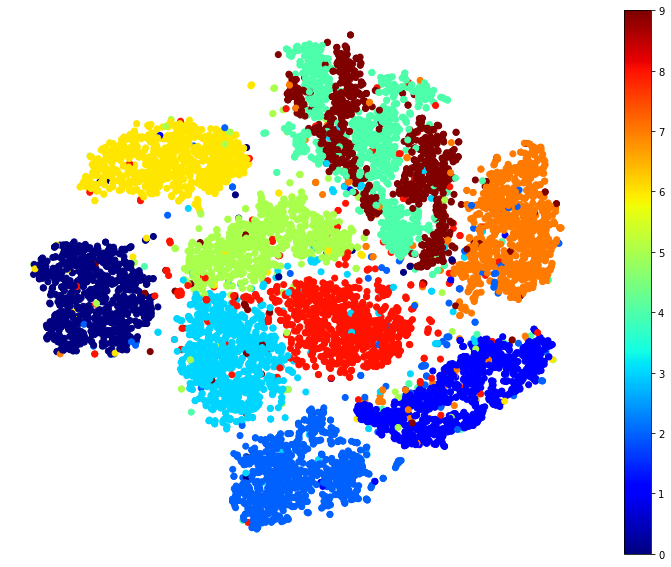

In [21]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()